## Part 2: Processing Data and Testing Models
Now that the transcripts have been generated using `data_generation.ipynb`, we can process the transcripts into features and labels to feed into different models.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
import math
import diffprivlib.models as dp
import numpy as np
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

Setting up the plotting libraries:

In [2]:
sns.set()

def plot():
    plt.figure(dpi=200, figsize=(8, 5))

Read the transcripts file generated from `data_generation.ipynb`:

In [3]:
transcripts = pd.read_csv('transcripts.csv', index_col=0, low_memory=False)
transcripts.head()

,DIRECTED STUDY,INTRODUCTION TO COMPUTER ENGINEERING,INTRODUCTION TO DISCRETE MATHEMATICS,MACHINE ORGANIZATION AND PROGRAMMING,DIGITAL SYSTEM FUNDAMENTALS,INTRODUCTION TO ARTIFICIAL INTELLIGENCE,PROBLEM SOLVING USING COMPUTERS,INTRODUCTION TO OPERATING SYSTEMS,INTRODUCTION TO ALGORITHMS,DATABASE MANAGEMENT SYSTEMS: DESIGN AND IMPLEMENTATION,...,MEDICAL IMAGE ANALYSIS,VIRTUAL REALITY,COMPUTER ANIMATION,INTRODUCTION TO COMPUTATIONAL GEOMETRY,FUNDAMENTALS OF HUMAN-COMPUTER INTERACTION,COMPUTATIONAL METHODS FOR MEDICAL IMAGE ANALYSIS,CONTEST-LEVEL PROGRAMMING,USER EXPERIENCE DESIGN 1,ADVANCED LINEAR PROGRAMMING,SENIOR THESIS
0,NaN,NaN,AB,NaN,NaN,NaN,NaN,NaN,BC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,BC,NaN,A,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,AB,BC,NaN,AB,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A,NaN,NaN,NaN,B,NaN,NaN,NaN,NaN,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,AB,AB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some helpful dictionaries to help us in converting data representations:

In [4]:
grade_to_label_dict = {'A': 1, 'AB': 2, 'B': 3, 'BC': 4, 'C': 5, 'D': 6, 'F': 7}
label_to_grade_dict = {value: key for key, value in grade_to_label_dict.items()}

In [5]:
course_to_index_dict = {column: i for i, column in enumerate(transcripts.columns)}
index_to_course_dict = {i: column for i, column in enumerate(transcripts.columns)}

#### Calculating the accuracy

Utility function to calculate the accuracy of a model. Instead of simply assigning a 0 score for a wrong grade prediction and a 1 score for a correct grade prediction, this function will report accuracies based on how far a grade prediction was, using the following formula:

$$Accuracy = \frac{1}{2^{distance}}$$
where distance is how far off the prediction is from the true grade.

So for example, if the correct grade was a B and the model predicted an AB, the accuracy will be 0.5 as the distance is 1. If the prediction was C, the distance is 2 and the accuracy would be 0.25.

Here's a graph showing the distance vs accuracy. Further distances are penalized more, and are considered more inaccurate.

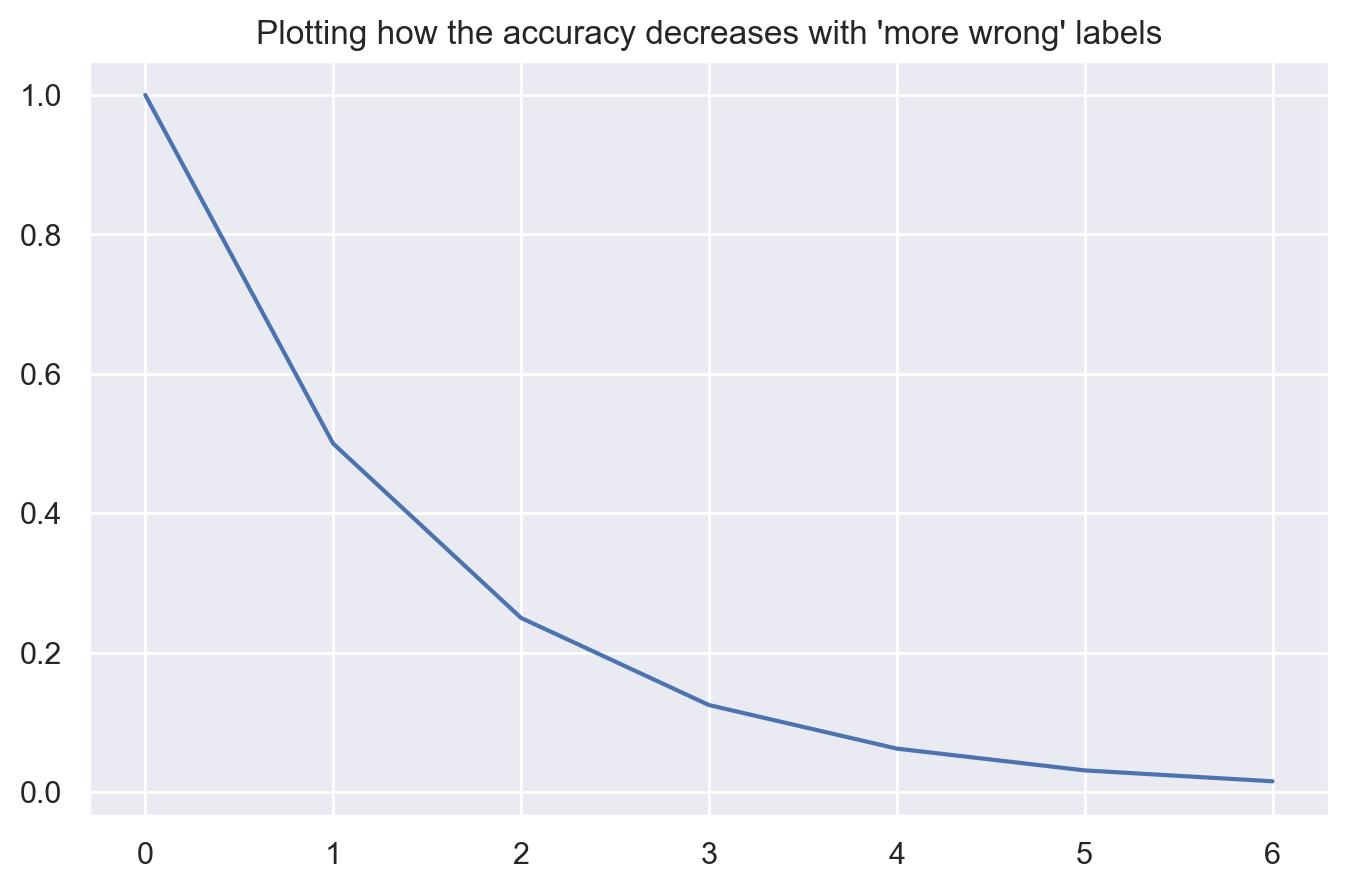

In [6]:
plot()
distances = list(range(len(grade_to_label_dict)))
accuracies = [1/math.pow(2, distance) for distance in distances]
sns.lineplot(x=distances, y=accuracies)
plt.title("Plotting how the accuracy decreases with 'more wrong' labels");

In [7]:
def calculate_accuracy(model, x_test, y_test):
    accuracy = 0
    for x, y in zip(x_test, y_test):
        y_pred = model.predict(x.reshape(1, -1))
        distance = abs(y - y_pred)
        accuracy += 1/(math.pow(2, distance))
    return accuracy/len(x_test)

### Approach 1

Take everything but one course from the transcripts as the features, and put that course as the label:

In [8]:
x = transcripts.drop(['PROGRAMMING I'], axis=1)
y = transcripts['PROGRAMMING I']

Let's check the number of columns for x:

In [9]:
pd.get_dummies(x).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 506 entries, DIRECTED STUDY_A to SENIOR THESIS_A
dtypes: uint8(506)
memory usage: 24.5 MB


Let's say that rows 51 through 150 have to be used for testing. The number of columns are:

In [10]:
pd.get_dummies(transcripts.loc[51:150].drop(['PROGRAMMING I'], axis=1)).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 51 to 150
Columns: 212 entries, DIRECTED STUDY_A to SENIOR THESIS_A
dtypes: uint8(212)
memory usage: 21.5 KB


Since the number of columns change every time we change a course or change the rows that are used to train or test the data, we cannot use this approach.

### Approach 2

We can preprocess the rows by dropping all courses that a student hasn't taken and converting the courses and grades to integer values:

In [11]:
def preprocess_data(row):
    row = row.dropna()
    items = []
    items.extend([course_to_index_dict[index] for index in row.index])
    items.extend([grade_to_label_dict[value] for value in row.values])
    return pd.Series(items)

transcripts_preprocessed = transcripts.apply(preprocess_data, axis=1)

In [12]:
transcripts_preprocessed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,2,8,20,32,34,40,48,52,2,4,1,1,1,1,1,2
1,2,4,10,15,27,46,68,77,4,1,3,2,1,1,1,2
2,1,2,4,9,32,37,52,54,2,4,2,1,3,2,3,4
3,0,4,9,15,17,36,41,46,1,3,3,1,2,1,1,1
4,2,8,9,17,26,34,37,41,1,2,2,1,1,1,1,1


Utility function to get the features for each course:

In [13]:
def get_subject_processed(row, subject):
    num_subjects = int(len(row) / 2)
    if subject in row[0:num_subjects].values:
        row = row.append(pd.Series(subject), ignore_index=True)
        index = row[row == subject].index[0]
        row = row.drop([index, index+num_subjects])
        return row.reset_index(drop=True)
    else:
        return None

def get_features_for_course(course, head=False):
    if head:
        df = transcripts_preprocessed.head().apply(get_subject_processed, args=(course,), axis=1) \
            .dropna().reset_index(drop=True)
    else:
        df = transcripts_preprocessed.apply(get_subject_processed, args=(course,), axis=1) \
            .dropna().reset_index(drop=True)
    if type(df) == pd.Series:
        return pd.DataFrame.from_dict(dict(df), orient='index')
    return df

Utility function to get the label for each course:

In [14]:
def get_labels_processed(row, subject):
    num_subjects = int(len(row) / 2)
    if subject in row[0:num_subjects].values:
        index = row[row == subject].index[0]
        return row[index+num_subjects]
    else:
        return None

def get_labels_for_course(course, head=False):
    if head:
        return transcripts_preprocessed.head().apply(get_labels_processed, args=(course,), axis=1).dropna().reset_index(drop=True)
    return transcripts_preprocessed.apply(get_labels_processed, args=(course,), axis=1).dropna().reset_index(drop=True)

Utility function to train and test a model with approach 2:

In [15]:
def train_model(model):
    x_tests = []
    y_tests = []
    for i in range(len(course_to_index_dict)):
        x = get_features_for_course(i)
        y = get_labels_for_course(i)
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        if len(x) > 0 and len(y_train.unique()) > 1:
            model.fit(x_train, y_train)
            x_tests.append(x_test)
            y_tests.append(y_test)
    
    x_tests = pd.concat(x_tests).reset_index(drop=True)
    y_tests = pd.concat(y_tests).reset_index(drop=True)
    accuracy = model.score(x_tests, y_tests)
    
    return (model, accuracy)

#### Logistic Regression Model

In [16]:
model = LogisticRegression(solver='sag', multi_class='multinomial', max_iter=10_000)
model, accuracy = train_model(model)
print(accuracy)

0.05698258950465915


#### Naive Bayes Model

In [17]:
model = GaussianNB()
model, accuracy = train_model(model)
print(accuracy)

0.20808811508909597


### Approach 3

Here we just replace all missing values with zeros and replace all grades with their integer representations:

In [18]:
transcripts_preprocessed = transcripts.fillna(0).replace(grade_to_label_dict).astype(int)

In [19]:
transcripts_preprocessed.head()

,DIRECTED STUDY,INTRODUCTION TO COMPUTER ENGINEERING,INTRODUCTION TO DISCRETE MATHEMATICS,MACHINE ORGANIZATION AND PROGRAMMING,DIGITAL SYSTEM FUNDAMENTALS,INTRODUCTION TO ARTIFICIAL INTELLIGENCE,PROBLEM SOLVING USING COMPUTERS,INTRODUCTION TO OPERATING SYSTEMS,INTRODUCTION TO ALGORITHMS,DATABASE MANAGEMENT SYSTEMS: DESIGN AND IMPLEMENTATION,...,MEDICAL IMAGE ANALYSIS,VIRTUAL REALITY,COMPUTER ANIMATION,INTRODUCTION TO COMPUTATIONAL GEOMETRY,FUNDAMENTALS OF HUMAN-COMPUTER INTERACTION,COMPUTATIONAL METHODS FOR MEDICAL IMAGE ANALYSIS,CONTEST-LEVEL PROGRAMMING,USER EXPERIENCE DESIGN 1,ADVANCED LINEAR PROGRAMMING,SENIOR THESIS
0,0,0,2,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,4,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,4,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,3,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0


Then we create copies of rows, one copy for each grade that exists in the row, and iteratively replace a grade with -1 and store the row as a feature and the grade as a label:

In [20]:
x = []
y = []
for index, grades in transcripts_preprocessed.iterrows():
    grade_indices = grades[grades != 0].index
    for course in grade_indices:
        new_grades = grades.copy()
        new_grades[course] = -1
        x.append(new_grades)
        y.append(grades[course])
x = np.asarray(x)
y = np.asarray(y)

Creating training and testing sets for approach 3:

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

## Training Models

In [22]:
# A default value of epsilon will be used to compare DP and non-DP versions of the same model
epsilon = 0.1

# Since the accuracy of a DP model changes everytime it's fitted, we will iterate a fixed number of times
# and calculate its average metrics
num_iterations = 10

# We'll be exploring the effect of different values of epsilon on DP models
epsilon_values = np.logspace(-2, 2, 10)

# Creating DataFrame objects to store our results
dp_effects_df = pd.DataFrame(columns=['Model Name', 'Epsilon', 'Iteration', 'Accuracy'])
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Max Error', 'R2 Score', 'Explained Variance'])
metrics_column_names = metrics_df.columns

Utility function to evaluate a model (either DP or non-DP):

In [23]:
def evaluate_model(model_name, model, num_iterations=1, plot_accuracies=False):
    accuracies = []
    max_errors = []
    r2_scores = []
    explained_variances = []
    for i in range(num_iterations):
        model.fit(x_train, y_train)
        accuracy = calculate_accuracy(model, x_test, y_test)
        y_pred = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        
        print("Iteration %d, accuracy: %f" % (i+1, accuracy))
        accuracies.append(accuracy)
        max_errors.append(max_error(y_train, y_pred_train))
        r2_scores.append(r2_score(y_test, y_pred))
        explained_variances.append(explained_variance_score(y_test, y_pred))

    metrics = pd.Series(index=metrics_column_names)
    metrics['Model'] = model_name
    metrics['Accuracy'] = sum(accuracies) / len(accuracies)
    metrics['Max Error'] = sum(max_errors) / len(max_errors)
    metrics['R2 Score'] = sum(r2_scores) / len(r2_scores)
    metrics['Explained Variance'] = sum(explained_variances) / len(explained_variances)
    
    if plot_accuracies:
        model_names = [model_name for _ in range(num_iterations)]
        df = pd.DataFrame(zip(model_names, accuracies), columns=['Model', 'Accuracy'])
        plot()
        sns.catplot(x='Accuracy', y='Model', data=df, kind='violin');
        plt.title('Accuracy Distribution for %d iterations of %s' % (num_iterations, model_name));

    return metrics

Utility function to evaluate the epsilon value of a DP model:

In [24]:
def dp_plot(model_name, model, e, num_iterations):
    df = pd.DataFrame(columns=dp_effects_df.columns)
    accuracies = []
    for i in range(num_iterations):
        print(".", end='')
        model.fit(x_train, y_train)
        accuracy = calculate_accuracy(model, x_test, y_test)
        y_pred = model.predict(x_test)
        
        accuracies.append(accuracy)
        metrics = pd.Series(index=df.columns)
        metrics['Model Name'] = model_name
        metrics['Epsilon'] = e
        metrics['Iteration'] = i
        metrics['Accuracy'] = accuracy
        df = df.append(metrics, ignore_index=True)
    print('')
    return df

### Non DP models

#### Logistic Regression Model

In [25]:
model = LogisticRegression(solver='sag', multi_class='multinomial', max_iter=10_000)
metrics_df = metrics_df.append(evaluate_model("Logistic Regression", model), ignore_index=True)

Iteration 1, accuracy: 0.623004


#### Naive Bayes Model
The Naive Bayes model has low accuray with the default parameters. We explore the `var_smoothing` values to see if accuracy can be improved.

In [26]:
smoothing_values = np.logspace(-9, 0, 10)
df = pd.DataFrame(columns=metrics_df.columns)
for v in smoothing_values:
    model = GaussianNB(var_smoothing=v)
    df = df.append(evaluate_model("Naive Bayes", model), ignore_index=True)

Iteration 1, accuracy: 0.506634
Iteration 1, accuracy: 0.506634
Iteration 1, accuracy: 0.506632
Iteration 1, accuracy: 0.506664
Iteration 1, accuracy: 0.506721
Iteration 1, accuracy: 0.507705
Iteration 1, accuracy: 0.514444
Iteration 1, accuracy: 0.550330
Iteration 1, accuracy: 0.612312
Iteration 1, accuracy: 0.622619


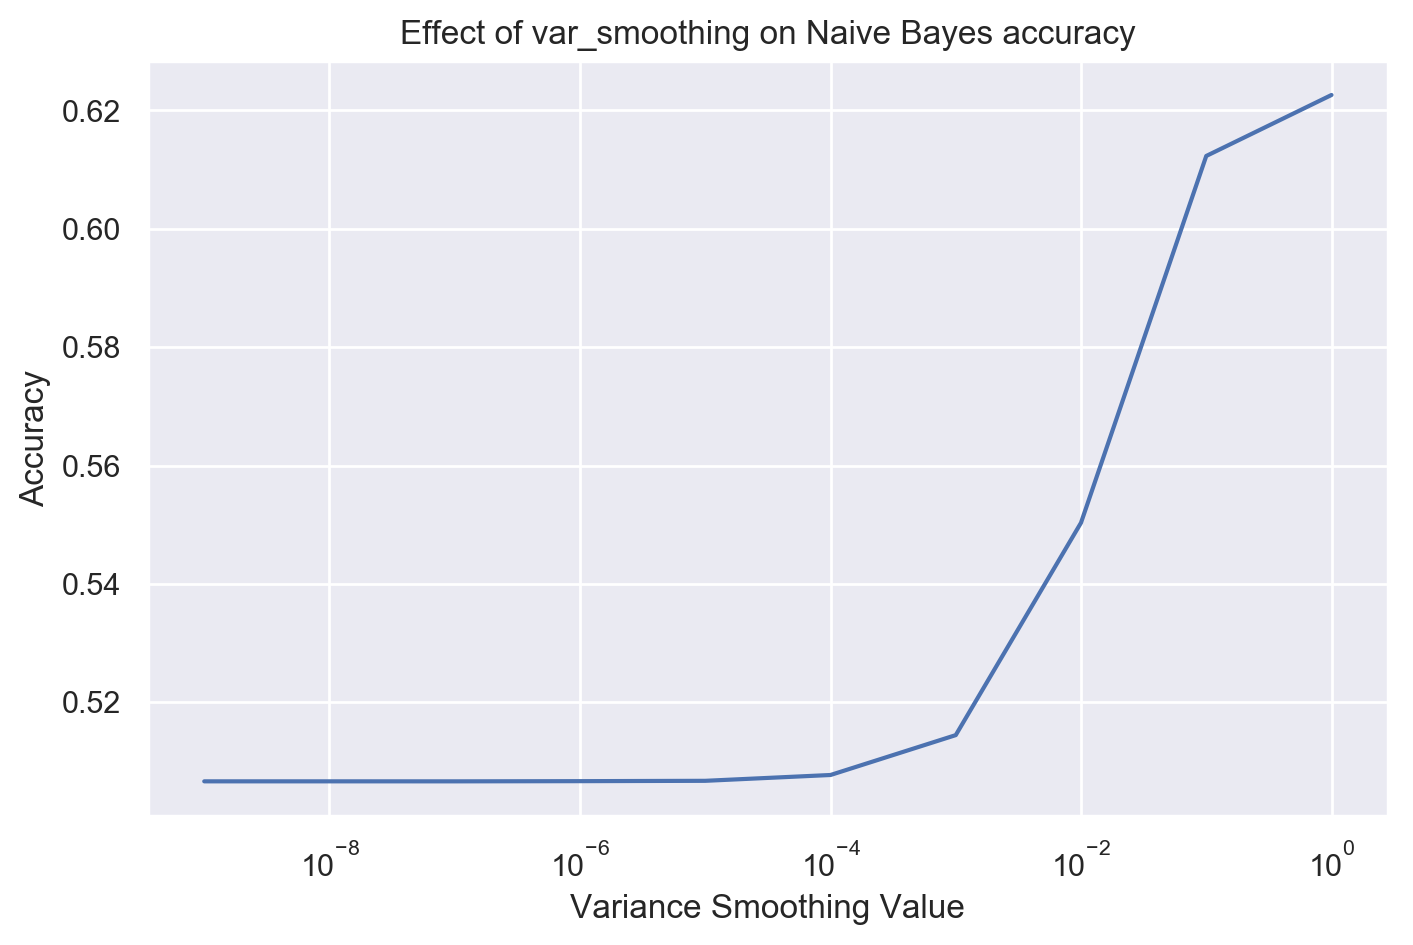

In [27]:
plot()
sns.lineplot(x=smoothing_values, y='Accuracy', data=df)
plt.xscale("log")
plt.xlabel("Variance Smoothing Value")
plt.title("Effect of var_smoothing on Naive Bayes accuracy");

In [28]:
model = GaussianNB(var_smoothing=1)
metrics_df = metrics_df.append(evaluate_model("Naive Bayes", model), ignore_index=True)

Iteration 1, accuracy: 0.622619


### Differential Privacy (DP) Models
For each DP model, 10 models are created and metrics are calculated for each model. The average is stored.

An interesting measure of the DP models is how the accuracy can vary across iterations, hence each model's accuracy distribution is displayed as a violin plot.

To interpret the violin plot, one must know that the x-axis is a possible accuracy value for an iteration, and the y-axis is the probability of that accuracy for any given iteration. In other words, the violin plot is a probability distribution of accuracy when training a DP model.

The middle "line" of the violin plot is a box-and-whisker plot, with the boxes showing the quartiles of the distribution and the whisker showing the rest of the distribution, excluding any outliers.

#### Logistic Regression Model with DP

Iteration 1, accuracy: 0.486277
Iteration 2, accuracy: 0.479670
Iteration 3, accuracy: 0.447590
Iteration 4, accuracy: 0.455334
Iteration 5, accuracy: 0.426031
Iteration 6, accuracy: 0.480376
Iteration 7, accuracy: 0.447503
Iteration 8, accuracy: 0.452812
Iteration 9, accuracy: 0.443940
Iteration 10, accuracy: 0.450322


<Figure size 1600x1000 with 0 Axes>

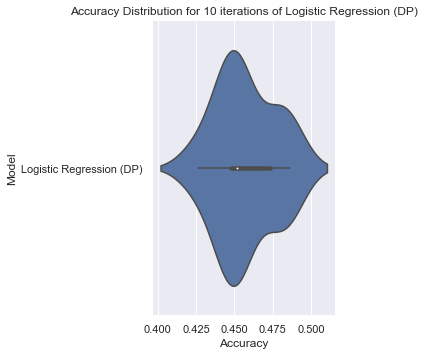

In [29]:
max_norm = np.linalg.norm(x_train, axis=1).max()
model = dp.LogisticRegression(max_iter=10_000, data_norm=max_norm, epsilon=epsilon)
model_name = "Logistic Regression (DP)"
metrics_df = metrics_df.append(evaluate_model(model_name, model, num_iterations=num_iterations, plot_accuracies=True), ignore_index=True)

In [30]:
for e in epsilon_values:
    model = dp.LogisticRegression(max_iter=10_000, data_norm=max_norm, epsilon=e)
    print("Evaluating with epsilon %f" % e, end='')
    dp_effects_df = dp_effects_df.append(dp_plot(model_name, model, e, num_iterations))

Evaluating with epsilon 0.010000..........
Evaluating with epsilon 0.027826..........
Evaluating with epsilon 0.077426..........
Evaluating with epsilon 0.215443..........
Evaluating with epsilon 0.599484..........
Evaluating with epsilon 1.668101..........
Evaluating with epsilon 4.641589..........
Evaluating with epsilon 12.915497..........
Evaluating with epsilon 35.938137..........
Evaluating with epsilon 100.000000..........


#### Naive Bayes Model with DP

Iteration 1, accuracy: 0.609067
Iteration 2, accuracy: 0.621552
Iteration 3, accuracy: 0.622539
Iteration 4, accuracy: 0.619804
Iteration 5, accuracy: 0.622642
Iteration 6, accuracy: 0.620044
Iteration 7, accuracy: 0.622196
Iteration 8, accuracy: 0.566352
Iteration 9, accuracy: 0.593841
Iteration 10, accuracy: 0.614171


<Figure size 1600x1000 with 0 Axes>

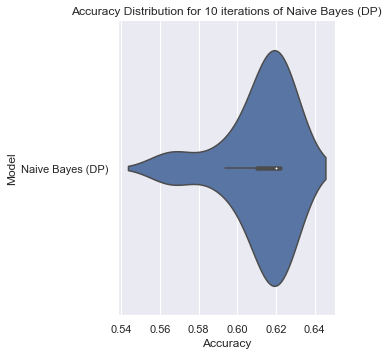

In [31]:
bounds = [(1, 7) for i in range(x_train.shape[1])]
model_name = "Naive Bayes (DP)"
model = dp.GaussianNB(bounds=bounds, epsilon=epsilon, var_smoothing=1)
metrics_df = metrics_df.append(evaluate_model(model_name, model, num_iterations=num_iterations, plot_accuracies=True), ignore_index=True)

In [32]:
for e in epsilon_values:
    model = dp.GaussianNB(bounds=bounds, epsilon=e, var_smoothing=1)
    print("Evaluating with epsilon %f" % e, end='')
    dp_effects_df = dp_effects_df.append(dp_plot(model_name, model, e, num_iterations))

Evaluating with epsilon 0.010000..........
Evaluating with epsilon 0.027826..........
Evaluating with epsilon 0.077426..........
Evaluating with epsilon 0.215443..........
Evaluating with epsilon 0.599484..........
Evaluating with epsilon 1.668101..........
Evaluating with epsilon 4.641589..........
Evaluating with epsilon 12.915497..........
Evaluating with epsilon 35.938137..........
Evaluating with epsilon 100.000000..........


In [33]:
metrics_df

,Model,Accuracy,Max Error,R2 Score,Explained Variance
0,Logistic Regression,0.623004,6.0,-0.637274,-6.234770e-03
1,Naive Bayes,0.622619,6.0,-0.659435,-2.220446e-16
2,Logistic Regression (DP),0.456985,6.0,-2.023530,-1.810242e+00
3,Naive Bayes (DP),0.611221,6.0,-0.520329,-4.402395e-02


## Results
The following section compares the metrics and performances of all 4 models:
1. Logistic Regression
1. Naive Bayes
1. Logistic Regression (DP)
1. Naive Bayes (DP)

One can easily compare different models, as well as the effect of the presence or absence of DP in models.

### Accuracy
This plot shows the accuracies for all the models. Please remember that the accuracy is calculated on a curved scale, as shown in one of the plots above. We can see that all models have about 60% accuracy, except Logistic Regression (DP). This could likely be due to the specific DP implementation of Logistic Regression and to support that theory we'll show below that increasing the value of epsilon improves the accuracy for the Logistic Regression (DP) model to be on par with the other models.

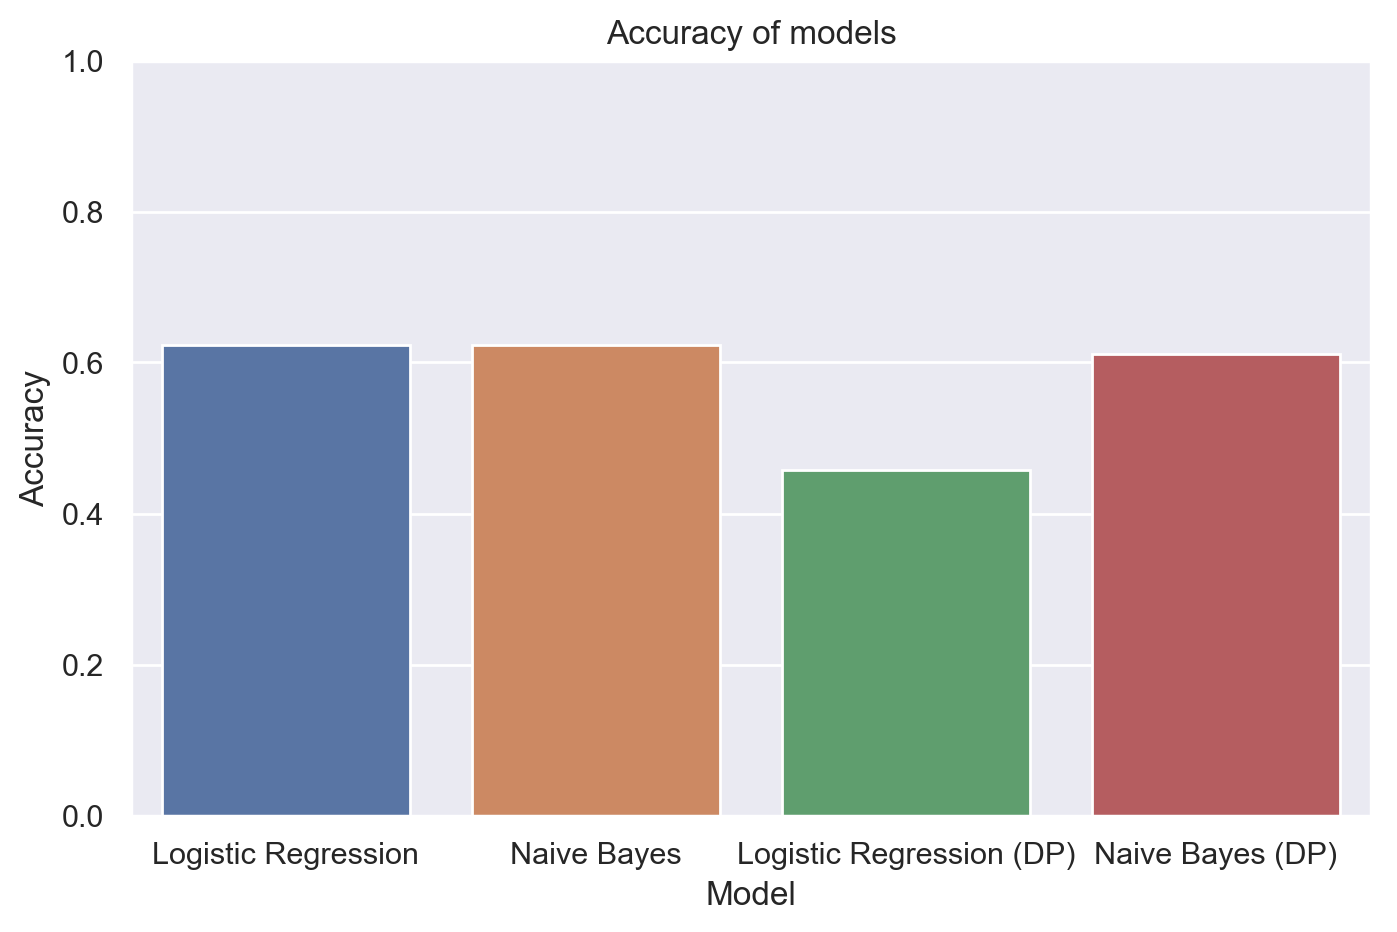

In [34]:
plot()
sns.barplot(x='Model', y='Accuracy', data=metrics_df)
plt.yticks(np.linspace(0, 1, 6))
plt.title("Accuracy of models");

### R2 Score
It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

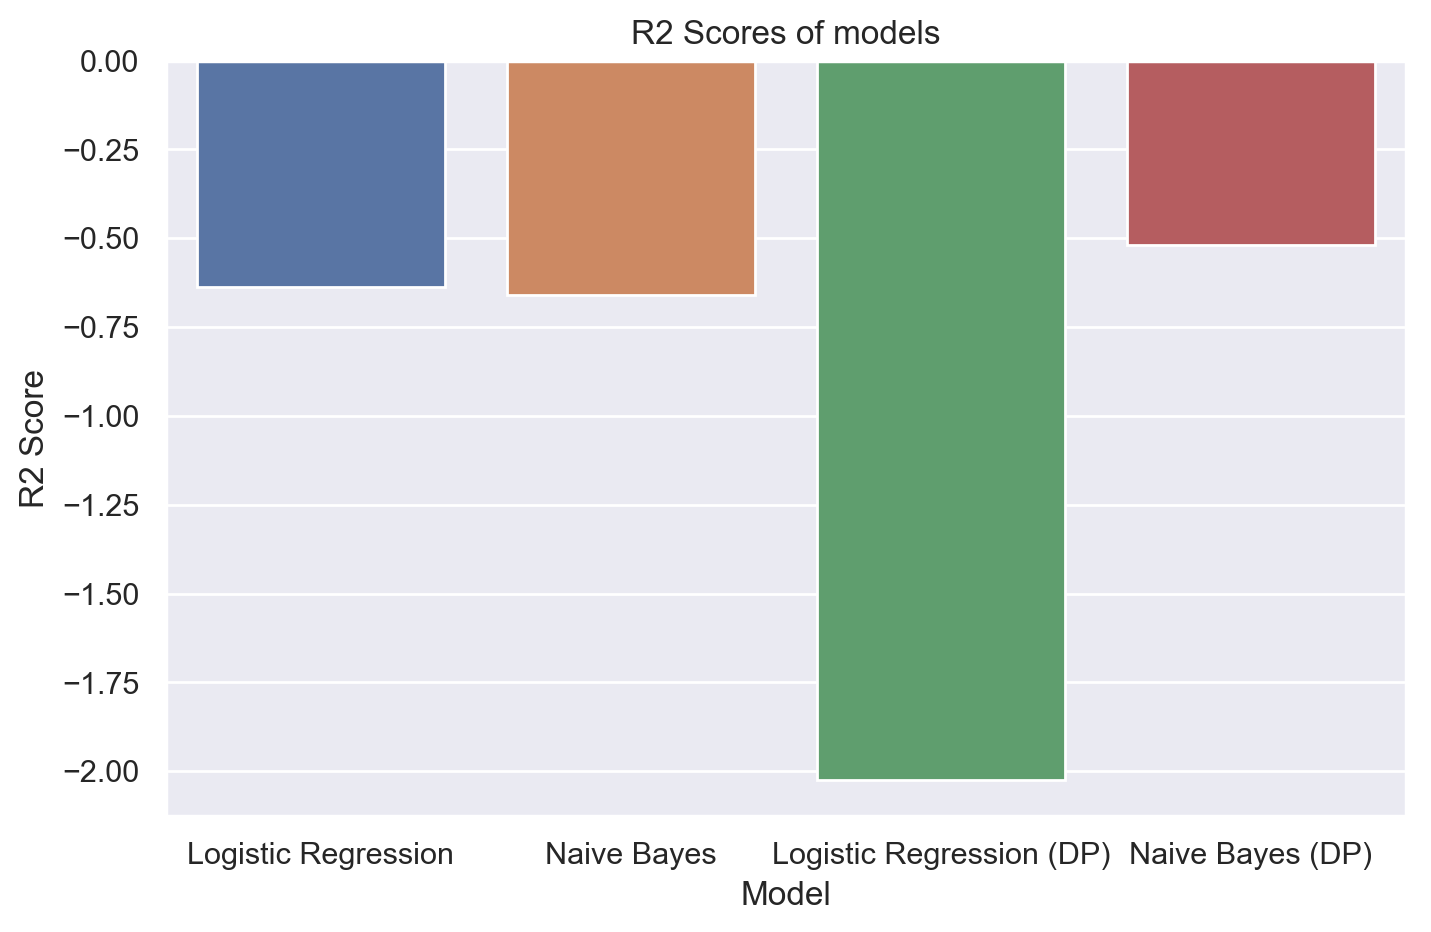

In [35]:
plot()
sns.barplot(x='Model', y='R2 Score', data=metrics_df)
plt.title("R2 Scores of models");

### Explained Variance
Explained variance measures the proportion to which a model accounts for the variation (or dispersion) of the data set.

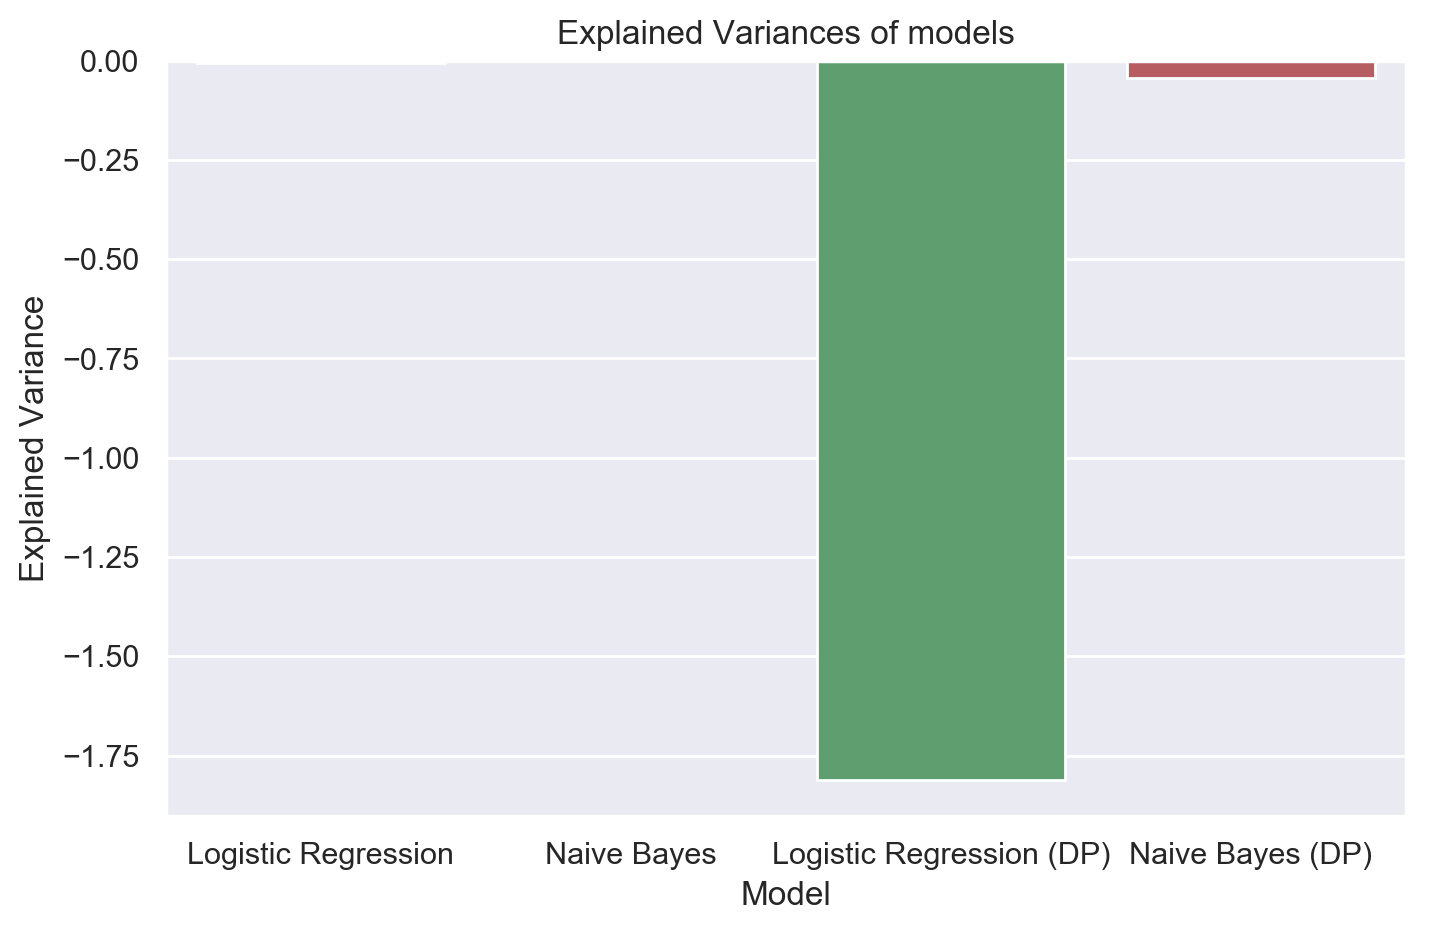

In [36]:
plot()
sns.barplot(x='Model', y='Explained Variance', data=metrics_df)
plt.title("Explained Variances of models");

### Max Error
This captures the worst case error between the predicted value and the true value. In a perfectly fitted single output regression model, max_error would be 0 on the training set and though this would be highly unlikely in the real world, this metric shows the extent of error that the model had when it was fitted.

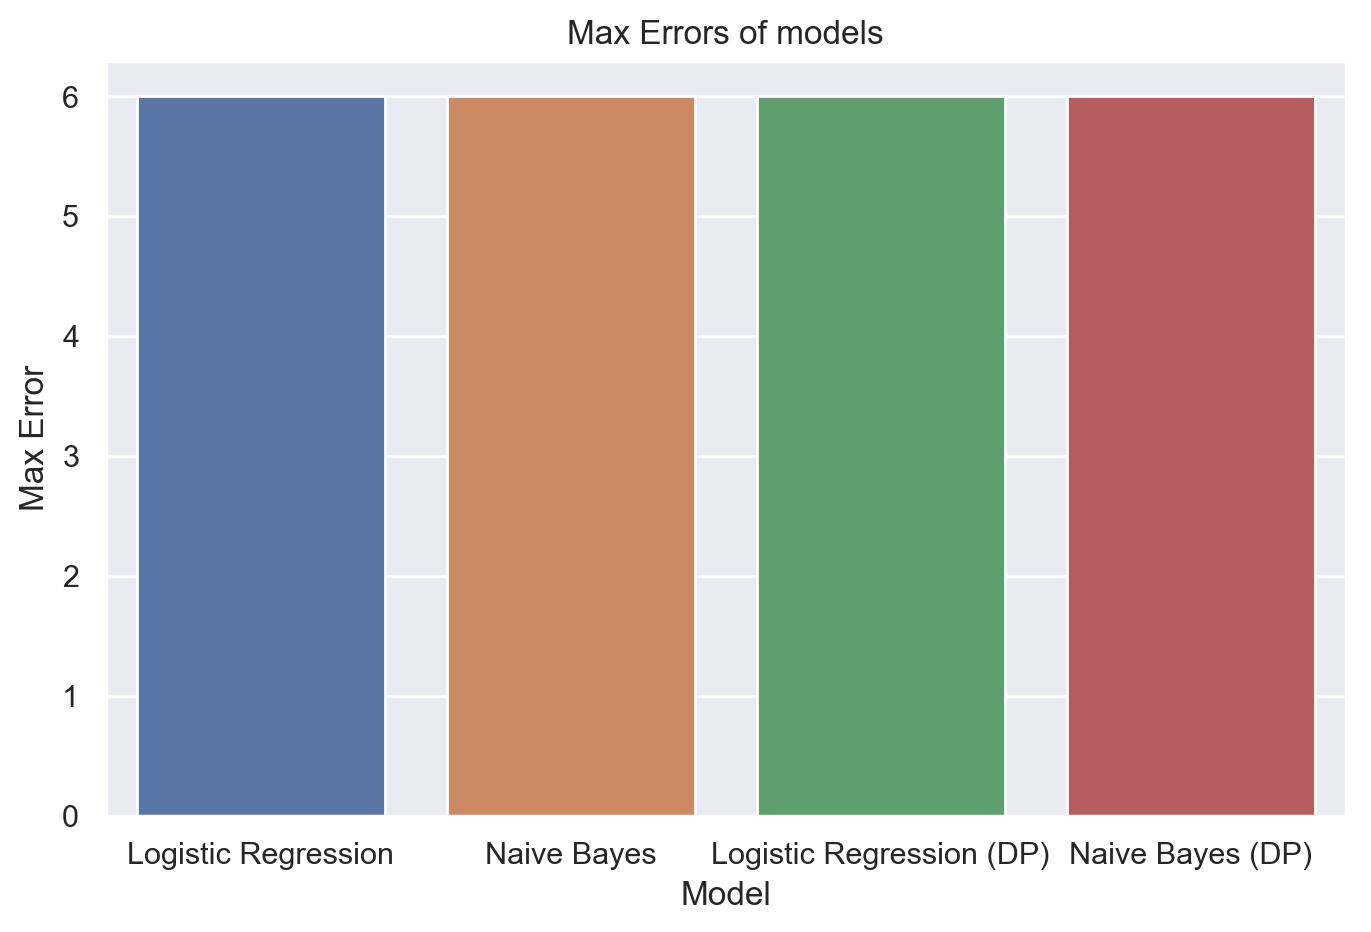

In [37]:
plot()
sns.barplot(x='Model', y='Max Error', data=metrics_df)
plt.title("Max Errors of models");

## Effects of Epsilon on a DP model's accuracy
The plot below shows how differing values of $\epsilon$ change the accuracy of a model. As expected, a higher value of $\epsilon$ allows the model to be more accurate. The shaded area around each line shows the confidence interval, which is a representation of the range of values that the model can have for a particular value of $\epsilon$. This interval also decreases with an increase in $\epsilon$, showing that the performance of a fitted model gets more predictable with larger values. Of course, higher values also mean lower privacy, so a plot of this kind can help a data curator select an appropriate value of $\epsilon$, to account for the trade-off between accuracy and privacy.

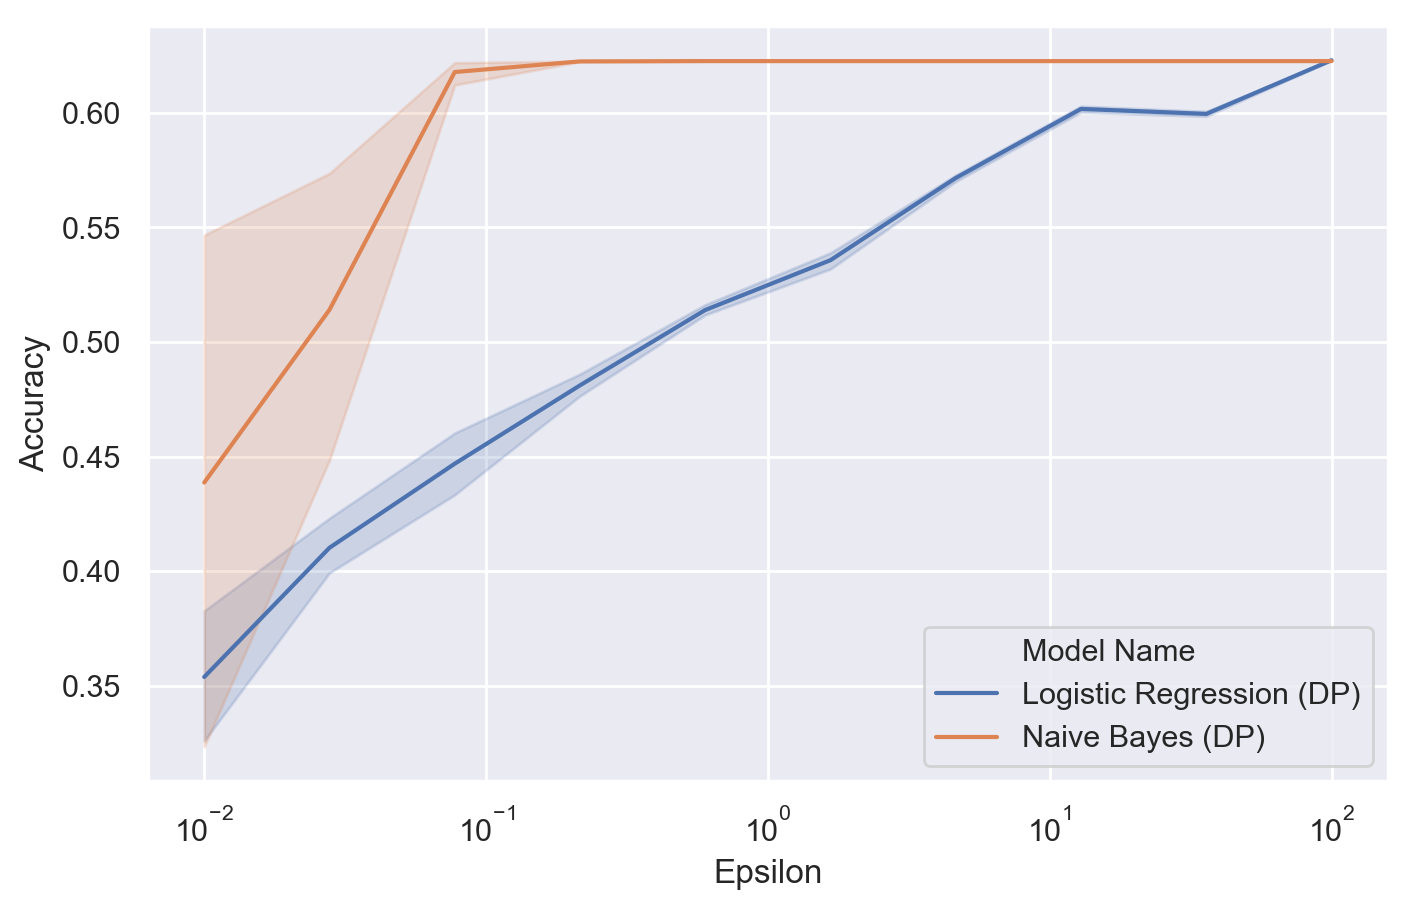

In [38]:
plot()
sns.lineplot(x='Epsilon', y='Accuracy', hue='Model Name', data=dp_effects_df)
plt.xscale("log")